In [1]:
import numpy as np
import os
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [12]:
# parameters
task = "visual"
artificial_delays = True
shared_delays = False
n_comp = 10  # 10 by default if artificial_delays==True and shared_delays==False
subsample = None

In [13]:
# get results from MVICAD
if artificial_delays:
    artificial_name = "_artificial_"
else:
    artificial_name = "_"
if shared_delays:
    shared_name = ""
else:
    shared_name = "multiple_"
if subsample:
    subsample_name = "_subsample" + str(subsample)
else:
    subsample_name = ""
algo = "mvicad_" + task + artificial_name + shared_name + "p" + str(n_comp) + subsample_name
save_path = "/storage/store2/work/aheurteb/mvicad/mlsp_results/%s/" % algo

# W_list
file_name = save_path + "W.npy"
if os.path.isfile(file_name):
    with open(file_name, "rb") as save_W_file:
        W_list = np.load(save_W_file)
else:
    print("W_list not found\n")

# tau_list
file_name2 = save_path + "tau_list.npy"
if os.path.isfile(file_name2):
    with open(file_name2, "rb") as save_delays_file:
        tau_list = np.load(save_delays_file)
else:
    print("tau_list not found\n")

# subjects if subsample
if subsample is not None:
    file_name3 = save_path + "subjects.npy"
    if os.path.isfile(file_name3):
        with open(file_name3, "rb") as save_subjects_file:
            subjects = np.load(save_subjects_file)
    else:
        print("subjects not found\n")

In [14]:
# load dataset
dataset_path = "/storage/store2/work/aheurteb/mvicad/data/"

if task == "visual":
    ages = np.load(dataset_path + "ages_visual_task_477.npy")
    if artificial_delays:
        if shared_delays:
            X_name = "X_visual_task_mag_477_artificially_delayed.npy"
        else:
            X_name = "X_visual_task_mag_477_artificially_delayed_multiple.npy"
    else:
        X_name = "X_visual_task_mag_477.npy"
elif task == "auditory":
    ages = np.load(dataset_path + "ages_auditory_task_501.npy")
    if artificial_delays:
        if shared_delays:
            X_name = "X_auditory_task_mag_501_artificially_delayed.npy"
        else:
            X_name = "X_auditory_task_mag_501_artificially_delayed_multiple.npy"
    else:
        X_name = "X_auditory_task_mag_501.npy"
else:
    raise ValueError("Wrong task name")

data = np.load(dataset_path + X_name)
if subsample is not None:
    data = data[subjects]
    ages = ages[subjects]

# preprocessing : PCA
if artificial_delays and not shared_delays:
    X = data
else:
    X = []
    for d in tqdm(data):
        _, D, v = np.linalg.svd(d, full_matrices=False)
        y = v[:n_comp]
        x = y * D[:n_comp, None]
        X.append(x)
    X = np.array(X)
m, _, n = X.shape
print(X.shape)

(477, 10, 701)


In [15]:
# modify delays
tau_list[tau_list > n // 2] -= n

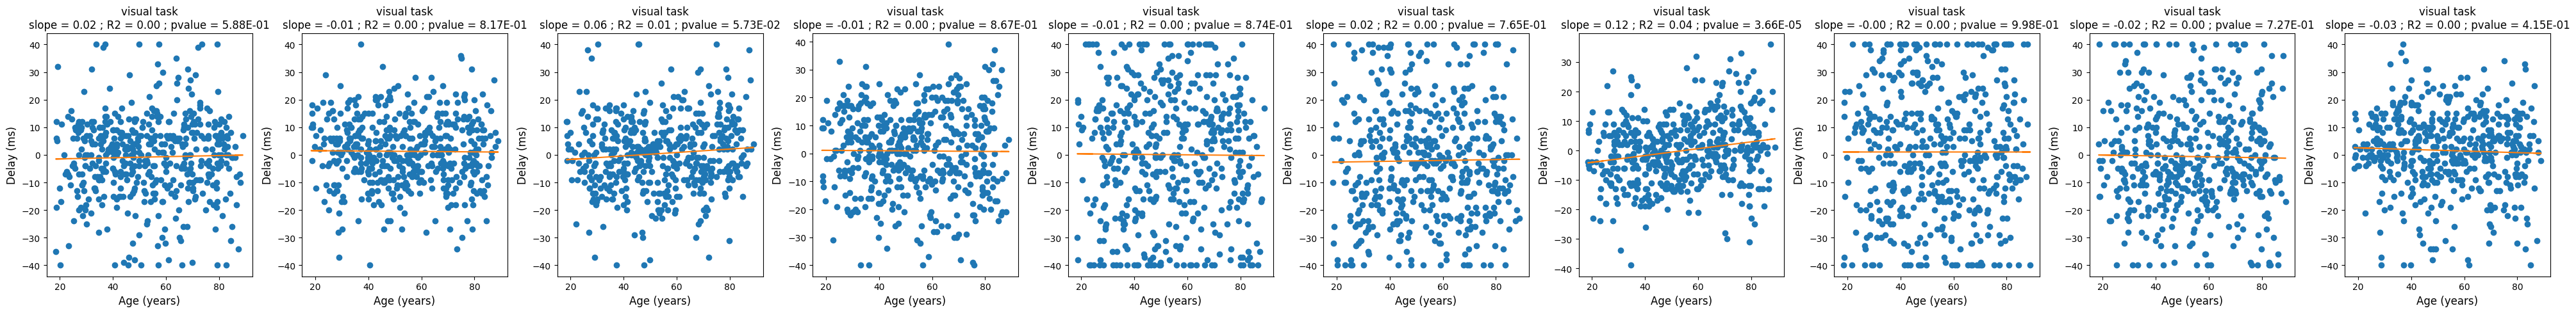

In [23]:
# function that plots the scatter plot age / delays for a specific source
def scatter_plot_age_delay(
    ages,
    delays,
    axis=None,
    xlabel="Age (years)",
    ylabel="Delay (ms)",
    save=False
):
    # colors
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    # Linear regression
    slope, intercept, _, _, _ = stats.linregress(ages, delays)
    fitLine = slope * ages + intercept

    # R2 score
    r2 = r2_score(delays, fitLine)

    # p-value
    pvalue = stats.pearsonr(ages, delays)[1]

    # Scatter plot
    if axis is None:
        # if xlabel == "Age (years)":
        #     figsize = (8, 6)
        # else:
        #     figsize = (5, 6)
        figsize = (8, 6)
        f, axis = plt.subplots(figsize=figsize)

    axis.scatter(ages, delays)
    axis.plot(ages, fitLine, c=colors[1])
    x_ = axis.set_xlabel(xlabel, fontsize=12)
    y_ = axis.set_ylabel(ylabel, fontsize=12)
    axis.set_title(
        "{} task\nslope = {:.2f} ; R2 = {:.2f} ; pvalue = {:.2E}".format(task, slope, r2, pvalue),
        fontsize=12);

    if save:
        save_folder = "/storage/store2/work/aheurteb/mvicad/mlsp_figures/"
        if xlabel == "Age (years)":
            save_name = "scatter_plot_age_delay_%s_task.jpeg" % task
        else:
            save_name = "scatter_plot_artificial_delays_%s_task.jpeg" % task
        plt.savefig(
            save_folder + save_name,
            bbox_extra_artists=[x_, y_], bbox_inches="tight")
    return slope

# scatter plot age delay
if shared_delays:
    scatter_plot_age_delay(ages, tau_list)
else:
    f, axes = plt.subplots(1, n_comp, figsize=(4*n_comp, 5))
    slopes = []
    for i in range(n_comp):
        slope = scatter_plot_age_delay(ages, tau_list[:, i], axes[i])
        slopes.append(slope)
    plt.tight_layout();

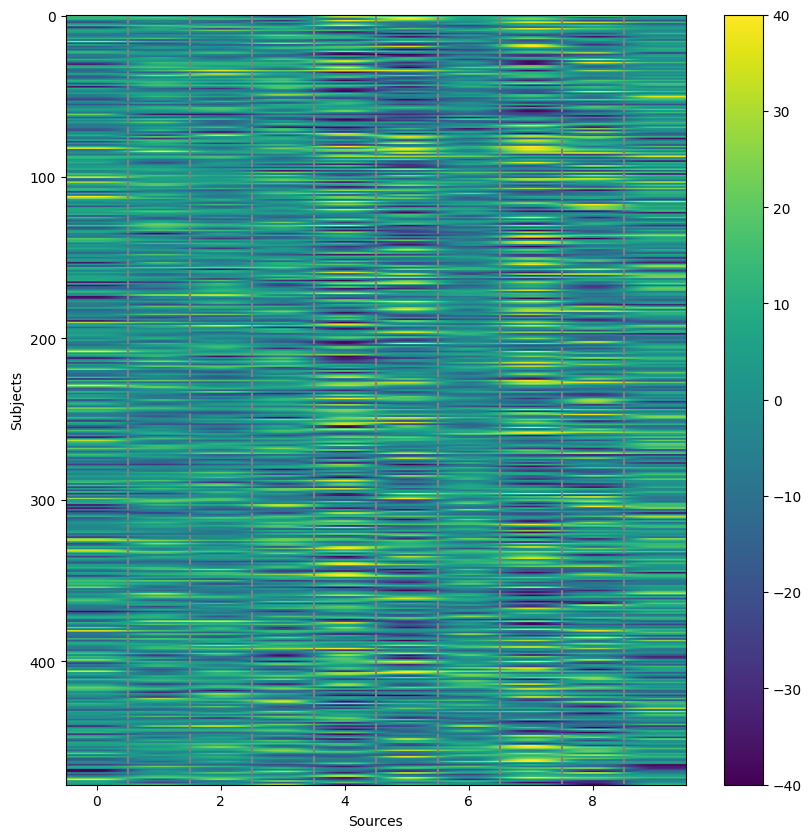

In [17]:
# heat map when using source-specific delays
if not shared_delays:
    plt.figure(figsize=(10, 10))
    plt.imshow(tau_list, aspect='auto')
    for i in range(n_comp-1):
        plt.vlines(x=i+0.5, ymin=0, ymax=len(tau_list)-1, colors='grey', linestyles='--')
    plt.colorbar()
    plt.xlabel("Sources")
    plt.ylabel("Subjects")

sources variance :  [222.71556593 151.7193149  171.83355968 220.5827389  512.50101745
 414.11039472 128.04180566 512.18306238 354.32870535 200.21209604]


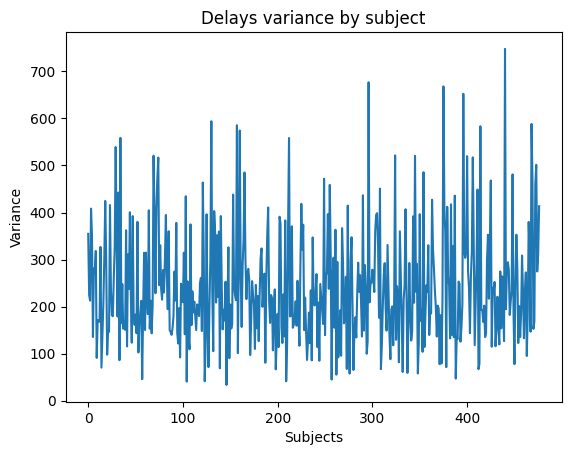

In [18]:
# variance when using source-specific delays
if not shared_delays:
    var_sources = np.var(tau_list, axis=0)
    print("sources variance : ", var_sources)
    plt.plot(np.var(tau_list, axis=1))
    plt.xlabel("Subjects")
    plt.ylabel("Variance")
    plt.title("Delays variance by subject");

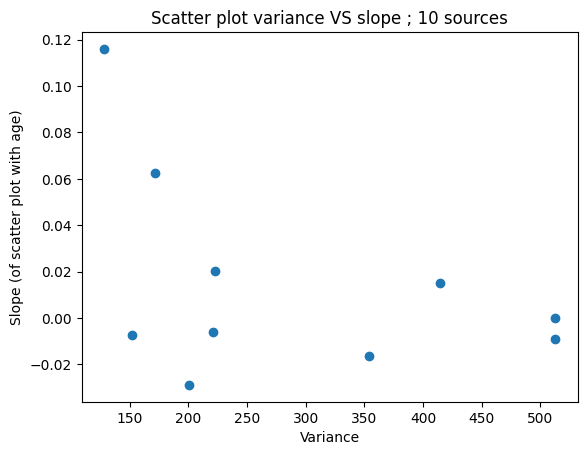

In [19]:
# scatter plot of variance VS slope
if not shared_delays:
    # each data point represents a source
    plt.scatter(var_sources, slopes)
    plt.xlabel("Variance")
    plt.ylabel("Slope (of scatter plot with age)")
    plt.title(f"Scatter plot variance VS slope ; {n_comp} sources");

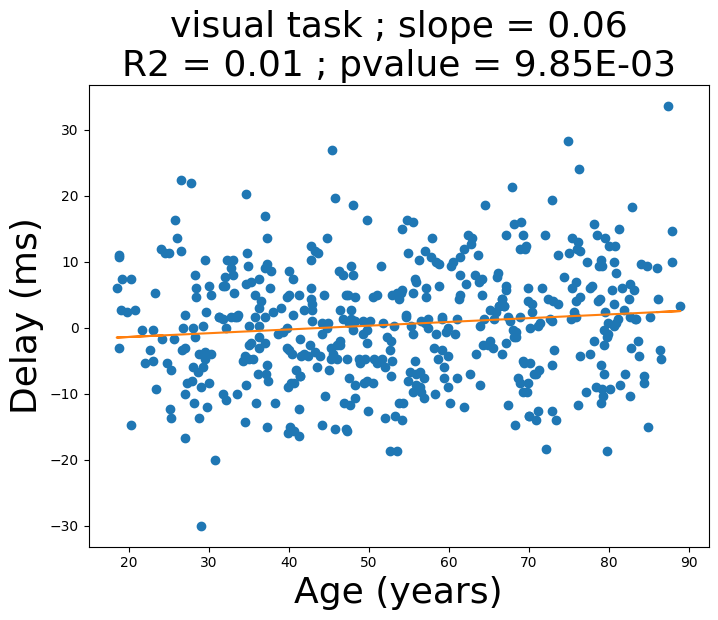

In [20]:
# scatter plot of age and averaged delays of the 3 sources with lowest variance
if not shared_delays:
    n_sources = 3
    sources_id = np.argsort(var_sources)[:n_sources]
    mean_delays = np.mean(tau_list[:, sources_id], axis=1)
    scatter_plot_age_delay(ages, mean_delays);

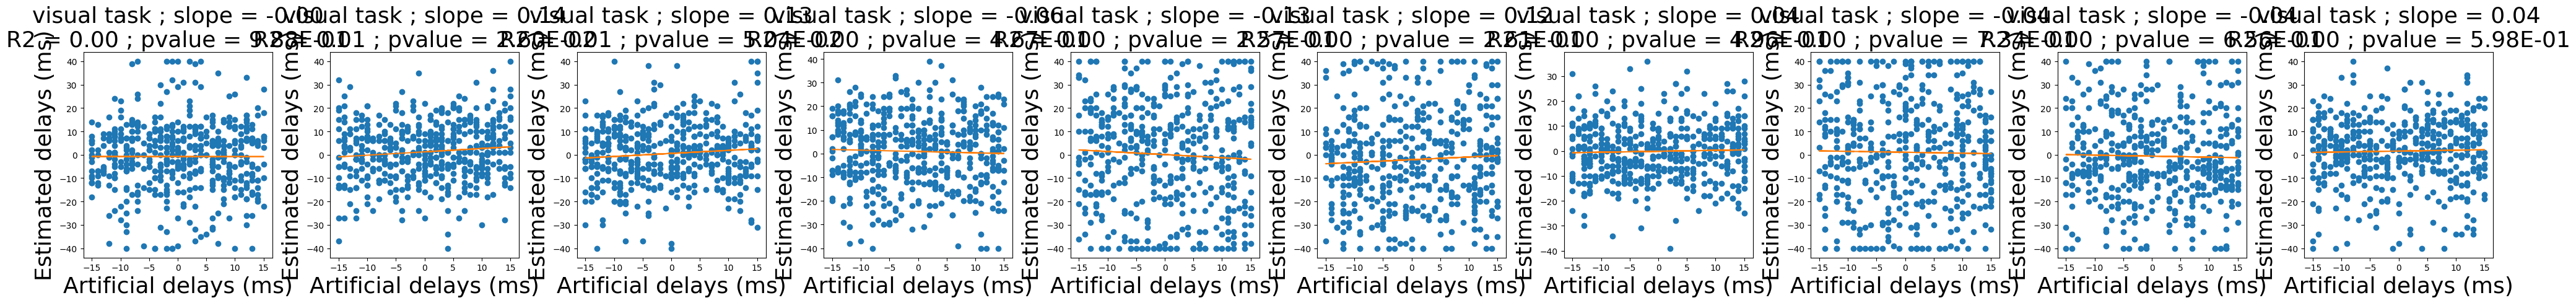

In [21]:
# compare estimated delays to true artificial delays
if artificial_delays:
    # load artificial delays
    dataset_path = "/storage/store2/work/aheurteb/mvicad/data/"
    if shared_delays:
        if task == "visual":
            delays_name = "artificial_delays_visual_task_mag_477.npy"
        elif task == "auditory":
            delays_name = "artificial_delays_auditory_task_mag_501.npy"
    else:
        if task == "visual":
            delays_name = "artificial_delays_multiple_visual_task_mag_477.npy"
        elif task == "auditory":
            delays_name = "artificial_delays_multiple_auditory_task_mag_501.npy"

    file_name4 = dataset_path + delays_name
    if os.path.isfile(file_name4):
        with open(file_name4, "rb") as save_art_delays_file:
            art_delays = np.load(save_art_delays_file)
    else:
        print("artificial delays not found\n")
    
    if shared_delays:
        scatter_plot_age_delay(
            art_delays,
            tau_list,
            xlabel="Artificial delays (ms)",
            ylabel="Estimated delays (ms)",
            save=True,
        )
    else:
        f, axes = plt.subplots(1, n_comp, figsize=(4*n_comp, 5))
        for i in range(n_comp):
            scatter_plot_age_delay(
                art_delays[:, i],
                tau_list[:, i],
                axes[i],
                xlabel="Artificial delays (ms)",
                ylabel="Estimated delays (ms)",
            )
        plt.tight_layout();

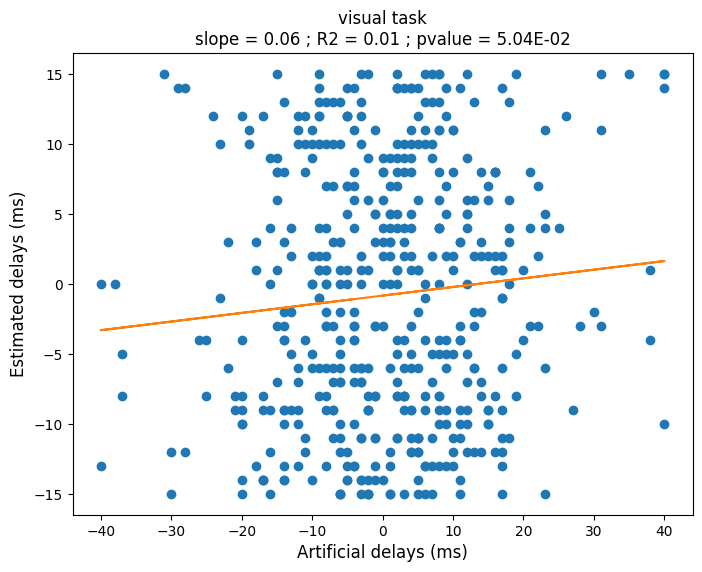

In [25]:
# scatter plot age delay in the best scenario
if task == 'visual' and artificial_delays and not shared_delays:
    best_source_id = 2
    scatter_plot_age_delay(
        art_delays[:, best_source_id],
        tau_list[:, best_source_id],
        xlabel="Artificial delays (ms)",
        ylabel="Estimated delays (ms)",
        save=True,
    )

In [67]:
# scatter plot age delay in the best scenario
if task == 'visual' and not artificial_delays and not shared_delays:
    best_source_id = 3
    scatter_plot_age_delay(ages, tau_list[:, best_source_id], save=True);